<font size="5">ASB Data Scientist Challenge</font>

by Kathlyn Sok 

# Challenge Overview

**Objective:**

Forecast daily and total sales in December 2020 using historical data to help determine if Vac-Attack are going to meet their targets and ensure that there is enough inventory to meet demand.

**Overview:**

Vac-Attack sells high-end vacuums using TV as the major advertising. The marketing team has advised that the marketing mix for advertising has changed a little as the business has gone more digital. The Marketing team believe that the release of the Ultra Edition Vac was received positively and generated more sales. Vac-attack sells through an 0508 number and their website. The marketing team provided the advertising spend for December 2020 with no expectation of competitions or new stories. The Ultra Vac will continue to be sold. The company aims to sell 3,900 units in December.
   

**Data Definitions:**

*(The data contains historical daily records of sales and expected predictors that you have gathered from 2016 through to November 2020.)*


`Date:` Date of event.

`Positive News:` A Positive News Story on Vac-Attack was released.

`Negative News:` A Negative News Story on Vac-Attack was released.

`Competition:` Vac-Attack runs competitions where you win a free Vac for your friend.

`AdvsertisingSpend:` Total Advertising Spend.

`Month:` Derived from Date. The Month name.

`Day:` Derived from Date. The day of the week.

`0508 Line:` A binary variable indicating when Vac-Attack had a 24/7 call line. They have since switched to fixed hours.

`UltraEdition:` A binary variable indicating when the Ultra Edition was made available.

`Covid Lockdown Indicator:` A binary variable indicating if lockodwn was imposed or not.

`Sales:` The units sold.

In [1]:
#importing libraries

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import itertools

#pip install prophet #need to be in python 3.9 or 3.10 to install prophet
# https://github.com/facebook/prophet/issues/2002
from prophet import Prophet 

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


/Users/kathycong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Importing plotly failed. Interactive plots will not work.


## 1. Gather the Data

In [2]:
#gathering marketing data
marketing_cols_df = pd.read_csv("data/MarketingCols.csv", names = ['col_name'])
marketing_cols = marketing_cols_df['col_name'].values.tolist()
marketing_df = pd.read_csv("data/MarketingSales.csv", names = marketing_cols) 

#Need to make explicitly specify the dateformat so it is parsed correctly
marketing_df.tail()

,Date,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,Month,Day,0508Line_247,UltraEdition_Available,COVID_Lockdown,Sales
1791,26/11/20,0,0,1,2238.03,November,Thursday,0,1,0,92
1792,27/11/20,0,0,1,6378.24,November,Friday,0,1,0,99
1793,28/11/20,1,0,1,12670.48,November,Saturday,0,1,0,115
1794,29/11/20,0,0,1,1317.66,November,Sunday,0,1,0,98
1795,30/11/20,0,0,1,4144.00,November,Monday,0,1,0,94


In [3]:
#Ensuring date format is correct so it is parsed correctly later on
marketing_df['Date'] = marketing_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%d/%m/%y'))
marketing_df.head()

,Date,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,Month,Day,0508Line_247,UltraEdition_Available,COVID_Lockdown,Sales
0,2016-01-01,0,0,0,4199.86,January,Friday,1,0,0,66
1,2016-01-02,0,0,0,14768.20,January,Saturday,1,0,0,84
2,2016-01-03,0,0,0,11019.79,January,Sunday,1,0,0,78
3,2016-01-04,0,0,0,3358.30,January,Monday,1,0,0,70
4,2016-01-05,0,0,0,5207.19,January,Tuesday,1,0,0,73


## 2.Cleaning & Exploratory Data Analysis

Based on the information provided by the marketing team, there is no expectations of competitions or new stories hence will only be analysing the variables: `AdvsertisingSpend`, `UltraEdition` and `Covid Lockdown Indicator` variables that may have an effect on our target variable, `Sales`. 



Time series is a set of data points ordered in time. Below are the components of a time series data.

`Trend` Observations are either increasing or decreasing over time.

`Seasonality` Observations show cycles due to the calendar (e.g. quarterly, monthly, annually etc).

`White noise` Time series data that is purely random.

`Cyclic` Observations rises and falls, but not due to a fixed period.


In [4]:
#checking no null values or missing values
marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    1796 non-null   datetime64[ns]
 1   PositiveNews            1796 non-null   int64         
 2   NegativeCoverage        1796 non-null   int64         
 3   Competition             1796 non-null   int64         
 4   AdvertisingSpend        1796 non-null   float64       
 5   Month                   1796 non-null   object        
 6   Day                     1796 non-null   object        
 7   0508Line_247            1796 non-null   int64         
 8   UltraEdition_Available  1796 non-null   int64         
 9   COVID_Lockdown          1796 non-null   int64         
 10  Sales                   1796 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(2)
memory usage: 154.5+ KB


In [5]:
#checking data values
marketing_df.describe()

,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,0508Line_247,UltraEdition_Available,COVID_Lockdown,Sales
count,1796.000000,1796.000000,1796.000000,1796.000000,1796.000000,1796.000000,1796.000000,1796.000000
mean,0.032294,0.008909,0.226615,7900.032372,0.304566,0.492762,0.028953,78.702116
std,0.176829,0.093991,0.418758,6235.046578,0.460351,0.500087,0.167722,22.361472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000
25%,0.000000,0.000000,0.000000,2953.030000,0.000000,0.000000,0.000000,64.000000
50%,0.000000,0.000000,0.000000,6583.465000,0.000000,0.000000,0.000000,77.000000
75%,0.000000,0.000000,0.000000,11558.735000,1.000000,1.000000,0.000000,92.000000
max,1.000000,1.000000,1.000000,46586.070000,1.000000,1.000000,1.000000,163.000000


In [6]:
#checking that there is no missing dates 
#there are 1796 observations and there 1796 days inclusive between min and max date thus there are no missing values

min_date = marketing_df['Date'].min()
max_date = marketing_df['Date'].max()
print("Min Date:", min_date)
print("Max Date:", min_date)
print((max_date - min_date).days + 1, "Total days from", min_date, "to", max_date)

Min Date: 2016-01-01 00:00:00
Max Date: 2016-01-01 00:00:00
1796 Total days from 2016-01-01 00:00:00 to 2020-11-30 00:00:00


In [7]:
#set date as the index but retaining Date as the column
df = marketing_df.set_index('Date', drop = False)

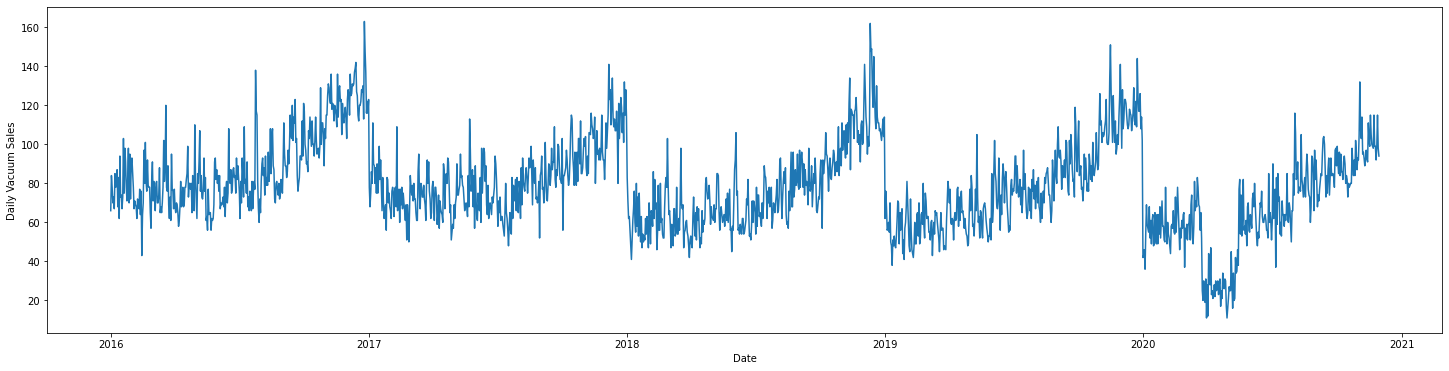

In [8]:
#Plotting Sales over time
#Based on the plot below it is evident that there seems to be a strong seasonality where Sales peaks at the end of each year
#There is also a cycle 
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(df['Sales'])
ax.set_xlabel('Date')
ax.set_ylabel('Daily Vacuum Sales');

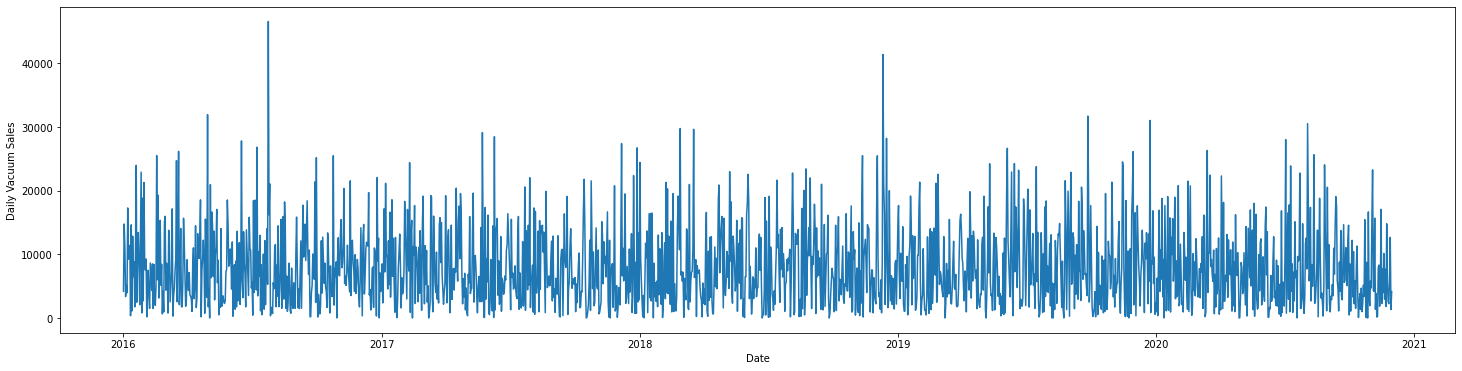

In [9]:
#Plotting AdvertisingSpend as it the only other variable where it is not boolean
#AdvertisingSpend doesn't seem to follow the same pattern as Sales. The pattern looks random.
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(df['AdvertisingSpend'])
ax.set_xlabel('Date')
ax.set_ylabel('Daily Vacuum Sales');

### Advertising Spend vs Sales
Below is a scatter plot of Sales and AdvertisingSpend.

It seems that there is a relationship between Advertising Spend and Sales. 
The higher the advertising spend the high the sales. 

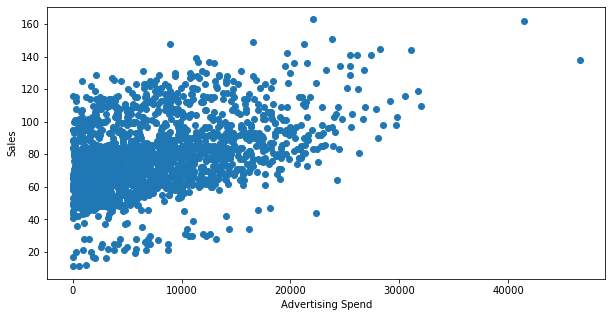

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df.AdvertisingSpend.values, df.Sales.values)
ax.set_ylabel('Sales')
ax.set_xlabel('Advertising Spend');

### COVID Lockdown vs Sales
It seems the cyclic behaviour or significant dip during the first quarter of 2020 is due to covid lockdown as seen on the plot below.

Min Covid Lockdown: 2020-03-25 00:00:00
Max Covid Lockdown: 2020-05-15 00:00:00


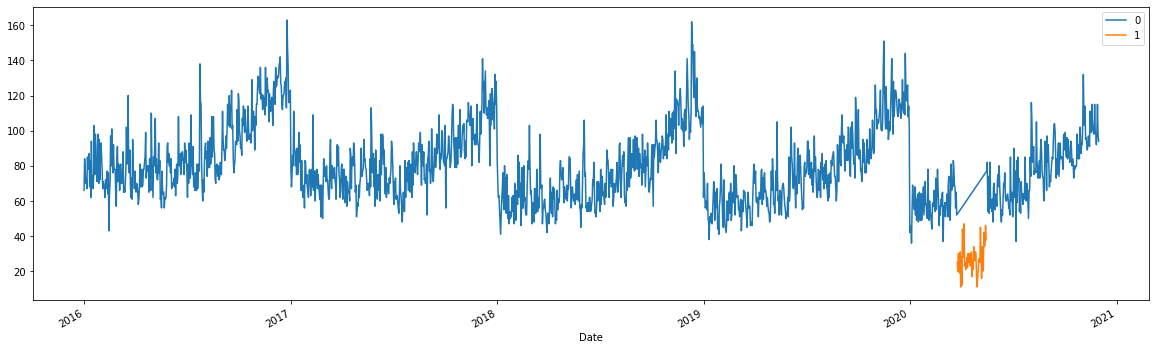

In [11]:
df[['Sales', 'COVID_Lockdown', 'Date']].set_index('Date').sort_index().groupby('COVID_Lockdown')['Sales'].plot(legend=True, figsize = (20, 6));

print("Min Covid Lockdown:", df[df['COVID_Lockdown'] == 1].Date.min())
print("Max Covid Lockdown:", df[df['COVID_Lockdown'] == 1].Date.max())

### UltraEdition vs Sales
It seems that the product prior to Ultra Edition Vacuum hasn't made a sale since 29-Jun-2018.
Since 30-June-2018, Vac-Attack sales is solely from the Ultra Edition based on the data we have been provided.

max_nonultraed: 2018-06-29 00:00:00 min_ultraed: 2018-06-30 00:00:00 max_ultraed: 2020-11-30 00:00:00


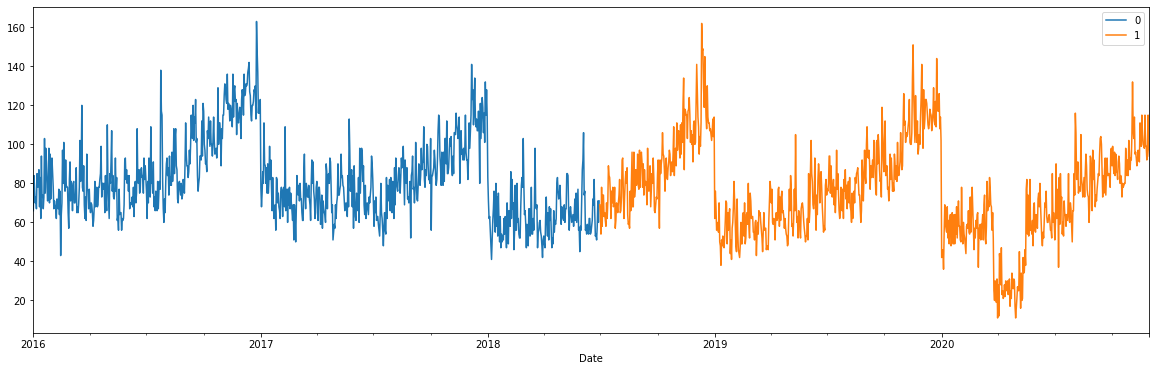

In [12]:
df[['Sales', 'UltraEdition_Available', 'Date']].set_index('Date').sort_index().groupby('UltraEdition_Available')['Sales'].plot(legend=True, figsize = (20, 6));

max_nonultraed = df[df['UltraEdition_Available'] == 0]['Date'].max()
min_ultraed = df[df['UltraEdition_Available'] == 1]['Date'].min()
max_ultraed = df[df['UltraEdition_Available'] == 1]['Date'].max()
print("max_nonultraed:", max_nonultraed, "min_ultraed:", min_ultraed, "max_ultraed:", max_ultraed)

### 0508 Line vs Sales
It seems that the 0508 line ceased from 30-June-2017. A year before UltraEdition vacuums were launched. Thus, will not be including products sold from 0508 line sales

min_0508Line_247: 2016-01-01 00:00:00 max_0508Line_247: 2017-06-30 00:00:00


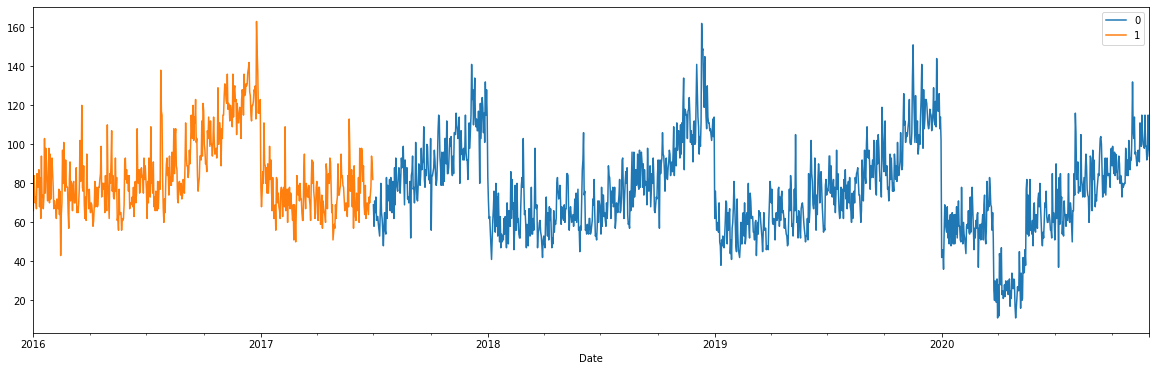

In [13]:
df[['Sales', '0508Line_247', 'Date']].set_index('Date').sort_index().groupby('0508Line_247')['Sales'].plot(legend=True, figsize = (20, 6));

df[df['0508Line_247'] == 1]['Date'].max()

min_0508Line_247= df[df['0508Line_247'] == 1]['Date'].min()
max_0508Line_247 = df[df['0508Line_247'] == 1]['Date'].max()
print("min_0508Line_247:", min_0508Line_247, "max_0508Line_247:", max_0508Line_247)

### Sales time series decomposition

Trend indicates that sales is decreasing over time.
Timeseries decomposition validates that there is seasonlity. This information will be quite helpful later on.

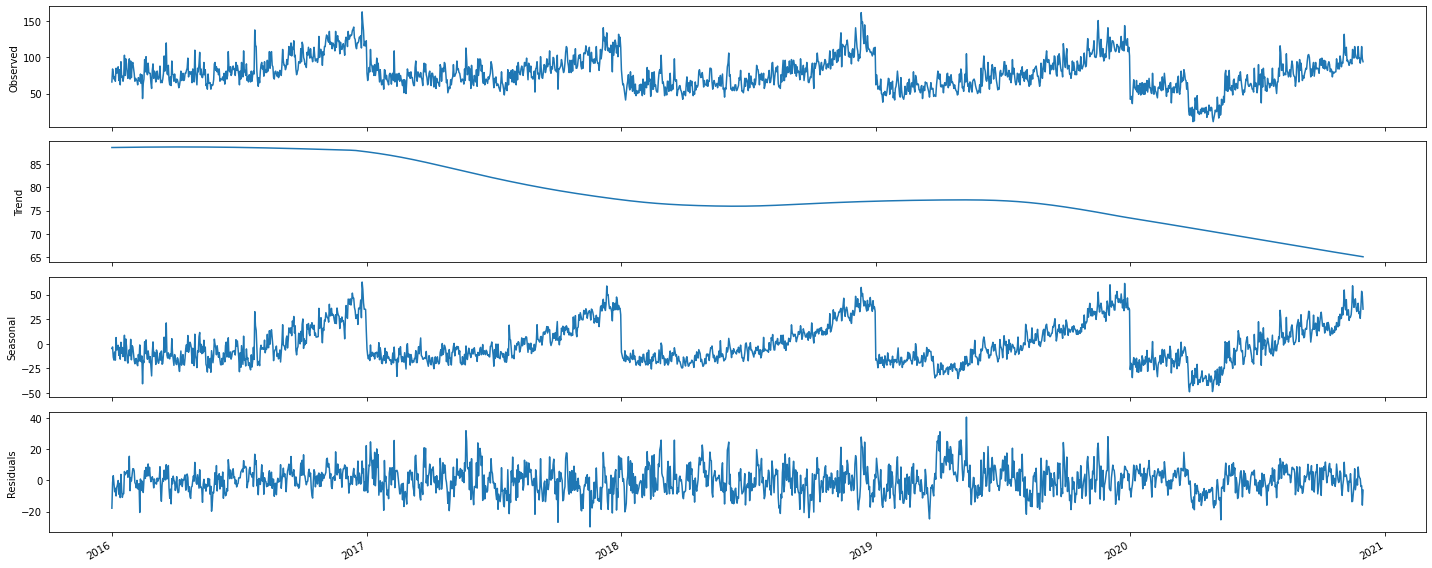

In [14]:
decomposition = STL(df['Sales'], period=365).fit()    # Period is 365 since we have yearly data

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## 3. Modelling

We are going to explore Prophet and SARIMAX models to predict Sales with `AdvertisingSpend` as the exogenous variable since other variables are related to time from the analysis conducted e.g. 0508 line occurred in a specific period and UltraEd vacuums also happened on a specific timeline.

### 3.1 Prophet with Advertising Spend as regressor/exogenous variable

Prophet is an open source package from Meta Open Source, meaning that it is built and maintained by Meta and uses the Fourier series to model multiple periodic effects.This library was built specifically for business forecasting at scale. It arose from the internal need at Facebook to produce accurate forecasts quickly, and the library was then made freely available. Prophet is arguably the best known forecasting library in the industry, as it can fit nonlinear trends and combine the effect of multiple seasonalities [1]. 

Prophet has the advantage of being much faster to estimate than the Dynamic Harmonic Regression (DHR) models, and it is completely automated. However, it rarely gives better forecast accuracy than the alternative approaches.  Also, Prophet is designed to work on seasonal time series [2].

Based on the timeseries decomposition, Sales has yearly seasonality hence Prophet would be suitable to predict future vacuum sales.

In [15]:
#prepping data for prophet modelling
prophet_df = df[['Date', 'Sales', 'AdvertisingSpend']]

In [16]:
#Prophet expects to have a DataFrame with two columns: a date column named ds and a value column named y. 
#The date column must have a format accepted by pandas—usually YYYY-MM-DD 
prophet_df.columns = ['ds', 'y', 'AdvertisingSpend']

In [17]:
#splitting data into train and test set
train = prophet_df[:-30]
test = prophet_df[-30:] #period is 30 as we are trying to predict Nov-20.

In [18]:
#training the data 
m = Prophet()
m.add_regressor('AdvertisingSpend')
m.fit(train)

#we want to forecast the next Nov-20 and see model performance for model selection
future = m.make_future_dataframe(periods=30) 


21:00:54 - cmdstanpy - INFO - Chain [1] start processing
21:00:54 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
#Appending regressor advertising spend for entire dataset, training and test sets which will be used during predictions
future = future.merge(df[['AdvertisingSpend', 'Date']].rename({'Date':'ds'}, axis = 1), on ='ds', how = 'left' )

In [20]:
#predicting Sales with Advertising spend as regressor
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)


,ds,yhat,yhat_lower,yhat_upper
1791,2020-11-26,91.443258,79.679729,103.083522
1792,2020-11-27,97.631000,86.408973,110.805939
1793,2020-11-28,107.189332,95.205144,118.095520
1794,2020-11-29,92.046881,80.109852,104.130990
1795,2020-11-30,95.956954,84.523761,108.125435


In [21]:
#only interested with Nov-20 predicted values
forecast_df = forecast[-30:].set_index('ds', drop = False)
forecast_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,AdvertisingSpend,AdvertisingSpend_lower,AdvertisingSpend_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-11-01,2020-11-01,69.517920,78.915851,104.173230,69.517920,69.517920,-4.638833,-4.638833,-4.638833,21.530400,...,0.751904,0.751904,0.751904,25.417329,25.417329,25.417329,0.0,0.0,0.0,91.048320
2020-11-02,2020-11-02,69.503177,94.295126,118.419938,69.503177,69.503177,10.697025,10.697025,10.697025,36.954210,...,-0.055161,-0.055161,-0.055161,26.312347,26.312347,26.312347,0.0,0.0,0.0,106.457388
2020-11-03,2020-11-03,69.488435,106.673012,129.795992,69.488435,69.488435,22.138024,22.138024,22.138024,48.680347,...,-0.622254,-0.622254,-0.622254,27.164577,27.164577,27.164577,0.0,0.0,0.0,118.168782
2020-11-04,2020-11-04,69.473693,80.181549,103.976437,69.473693,69.473693,-5.215447,-5.215447,-5.215447,22.552568,...,-0.193922,-0.193922,-0.193922,27.961937,27.961937,27.961937,0.0,0.0,0.0,92.026260
2020-11-05,2020-11-05,69.458950,80.663195,105.909011,69.458950,69.458950,-5.391712,-5.391712,-5.391712,23.384135,...,0.082384,0.082384,0.082384,28.693463,28.693463,28.693463,0.0,0.0,0.0,92.843085


In [22]:
#appending predicted values to test data to compare with actual values
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast_df[['yhat', 'yhat_lower', 'yhat_upper']]

In [23]:
prophet_results = test.copy()

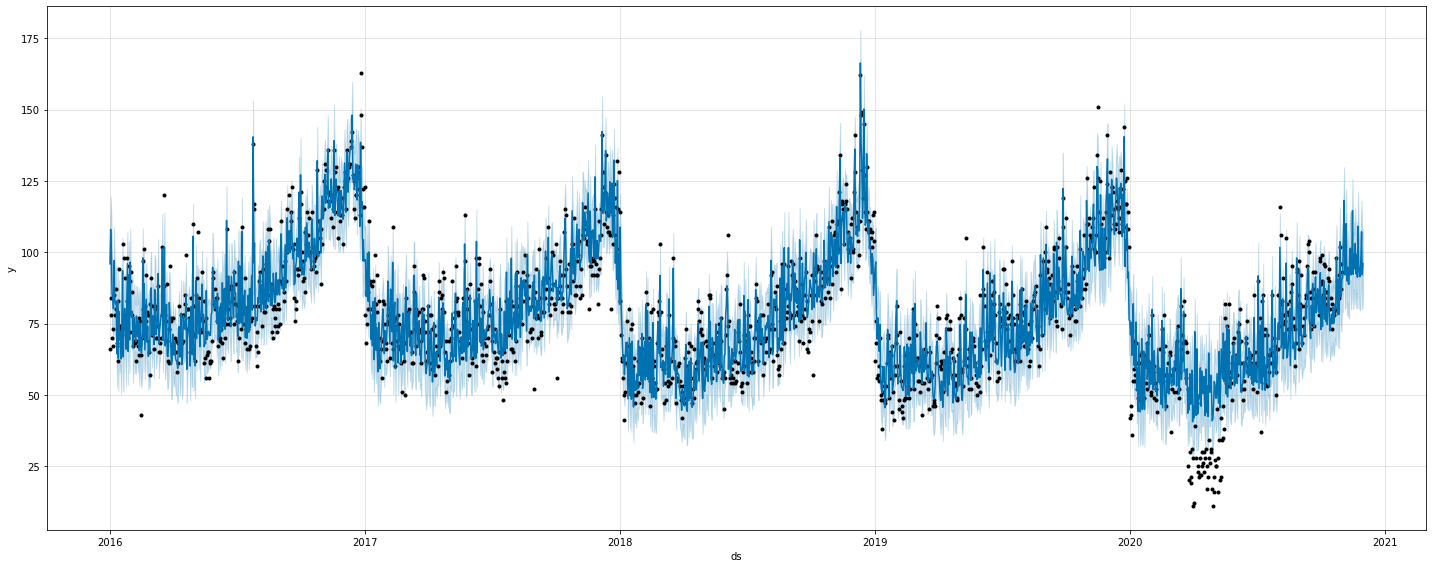

In [24]:
#Plotting our predictions using Prophet. 
#The black dots represent the training data, while the solid continuous line represents the model’s predictions. 
#The shaded band surrounding the line represents an 80% confidence interval.
#From below plot, Prophet didn't perform well with the cycle attributed from COVID Lockdown
fig1 = m.plot(forecast, figsize =(20, 8))

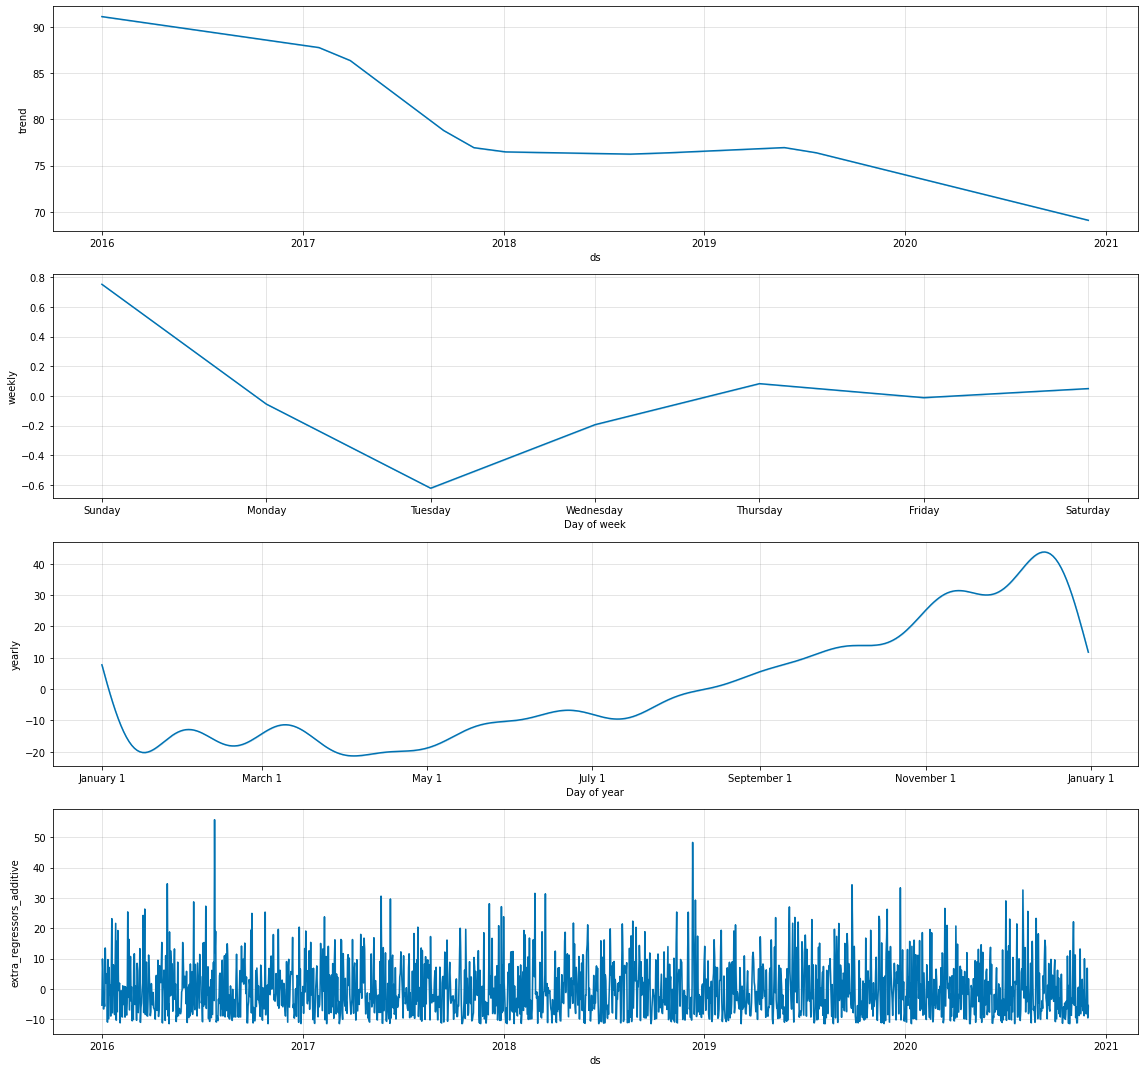

In [25]:
#Displaying the components of our model. 
#Here our model uses a trend component and two different seasonal components—one with a weekly period and the other with a yearly period.

fig2 = m.plot_components(forecast, figsize =(16, 15))

### 3.2 SARIMAX

Based on the timeseries decomposition plot, it is evident that the timeseries has seasonality hence will be using SARIMAX which takes into account AdvertisingSpend as the exogenous variable.

**Auto-Regressive Integrated Moving Average (ARIMA)** is a forecasting technique that usually provides accurate forecats with data that involves multiple independent variables (adverstising spend) that influence our dependent (sales).

The **SARIMA(p,d,q)(P,D,Q)m** model expands on the ARIMA(p,d,q) model from by adding seasonal parameters. The additional four parameters in the model: P, D, Q, and m. The first three have the same meaning as in the ARIMA(p,d,q) model, but they are their seasonal counterparts while the parameter m stands for the frequency.



#### 3.2.1 Testing stationarity

Stationary refers to time series whose statisical properties do not change over time. It has a constant mean, variance, and autocorrelation, and these properties are independent of time.

**Augmented Dickey-Fuller (ADF)** test helps determine if a time series is stationay by testing for the presence of a unit root. If a unit root is present, the time series is not stationary.

Set d equal to the number of times the series was differenced.


Set D equal to the number of times seasonal differencing was applied.



In [26]:
#The ADF Statistics of -3.67 and p-value of 0.005 refers that our time series is stationary thus there is no need to apply a transformation to our data to make it stationary (e.g. firs-order differencing)
ADF_result = adfuller(df['Sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.671108413787345
p-value: 0.004538389274360477


In [27]:
#Differencing without taken into consideration seasonality hence n= 1
#The ADF statistic is significantly negative however the ADF statistic is larger than 0.05 so we cannot reject 
#the null hypothesis that the time series is stationary

df_diff = np.diff(df['Sales'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.686720645205835
p-value: 3.5875661066085586e-30


In [28]:
#getting a significant negative ADF statistic after applying some transformation while p-value has reduced to 0
#Below we are applying seasonal differnecing. Since we have a daily data, m = 365, so the difference between two values that are 365 timesteps apart
#The series is now stationary. Therefore, we set d=1 and D=1.
df_diff = np.diff(df['Sales'], n=365)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print("Setting d=1 and D=1) based on above results from ADF test")

ADF Statistic: -37.391800924129775
p-value: 0.0
Setting d=1 and D=1) based on above results from ADF test


#### 3.2.2 Optimal p, q, P, Q parameters

- Fit every combination of SARIMAX(p,d,q)(P,D,Q)m
- Select model with lowest AIC

`p` The order of the autoregressive process.

`d` The order of integration. Integration is the reverse of differencing, and the order of integration d is equal to the number of times the series has been differenced to be rendered stationary.

`q` The order of the moving average process.

`m` Frequency.

`P`, `D` and `Q` hare the seasonal counterparts p, d q.



`Akaike information criterion (AIC)`
The Akaike information criterion (AIC) is a measure of the quality of a model in relation to other models. It is used for model selection. The lower the value of the AIC, the better the model. Selecting according to the AIC allows us to keep a balance between the complexity of a model and its goodness of fit to the data.


*Note: Bayesian information criterion (BIC) can also be used for model selection. It is similar to AIC select for the model that explains the greatest amount of variation using the fewest possible independent variables. Both Maximum Likelihood Estimation (MLE), and they both penalize a model for having increasing numbers of variables to prevent overfitting.*

In [29]:
#splitting data into target and train datasets
target = df['Sales']
exog = df['AdvertisingSpend']

target_train = target[:-30]
exog_train = exog[:-30]
target_test = target[-30:]
exog_test = exog[-30:]

In [30]:
# Define the p, d and q parameters to take any value
p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])


                #ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:10]
    
    return ans_df
    

In [31]:
#Unfortunately let this did not converged so decied to plot ACF and PACF to obtain p, q values and P, Q values are arbitrary
results = sarimax_gridsearch(target_train, pdq, pdqs, maxiter= 100000000000000, freq='D')
results

,pdq,pdqs,bic


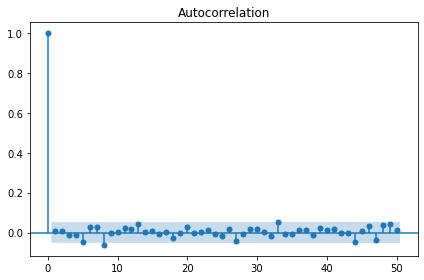

In [32]:
#plotting ACF to find q (AM)
#Based on the ACF plot the last significant coefficient is 5 and mostly closed to zero.  Hence q = 5

plot_acf(df_diff, lags=50);

plt.tight_layout()

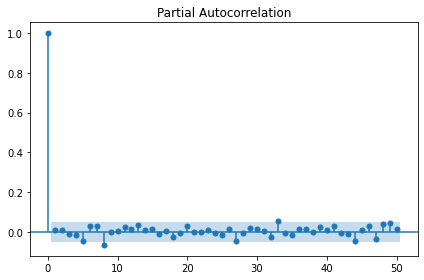

In [33]:
#plotting PACF to find p(AR)
#Based on the ACF plot the last significant is 5 coefficient and mostly closed to zero.  Hence p = 5

plot_pacf(df_diff, lags=50);

plt.tight_layout()

In [34]:
#Note that I attempted seasonality of m=365 but it was taking so much time so decided to change m = 7 which refers to weekly seasonality
model = SARIMAX(target_train, exog_train, order=(5,1,5), seasonal_order=(1,1,1,7), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                 1766
Model:             SARIMAX(5, 1, 5)x(1, 1, [1], 7)   Log Likelihood               -6218.405
Date:                             Sun, 15 Jan 2023   AIC                          12464.809
Time:                                     21:01:21   BIC                          12541.416
Sample:                                 01-01-2016   HQIC                         12493.122
                                      - 10-31-2020                                         
Covariance Type:                               opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
AdvertisingSpend     0.0012   3.85e-05     31.855      0.000       0.001       0.001
ar.L1    

#### 3.2.3 Residual Analysis

We need to perform residual analysis to assess whether our model is a good fit to the data.

`Quantile-quantile plot (Q-Q plot)` 
A graphical tool for verifying our hypothesis that the model’s residuals are normally distributed.
The Q-Q plot is constructed by plotting the quantiles of our residuals on the y-axis against the quantiles of a theoretical distribution, in this case the normal distribution, on the x-axis. This results in a scatterplot. We are comparing the distribution to a normal distribution because we want the residuals to be similar to white noise, which is normally distributed.


`Ljung-Box test` A signficance test to determine if data are white noise. A small p-value indicates the data are probably not white noise. 

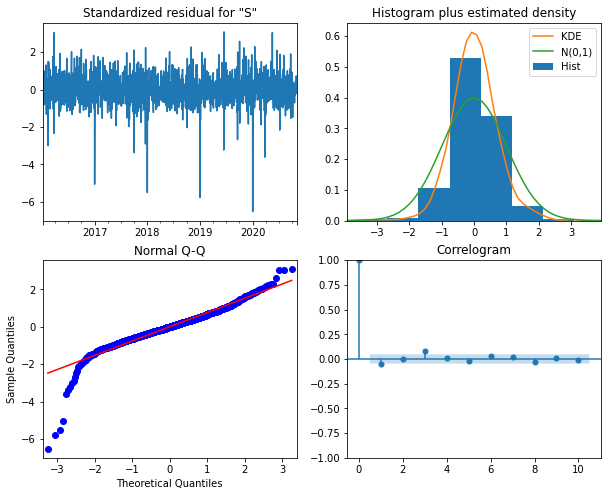

In [35]:
#Residual analysis of the selected model. 
#You can see that the residuals have no trend and a fairly constant variance over time, just like white noise. 
#In the top-right plot, the distribution of residuals is very close to a normal distribution. 
#This is further supported by the Q-Q plot at the bottom left, which shows a fairly straight line that lies on y = x. 
#Finally, the correlogram shows no significant coefficients after lag 0, just like white noise. 
#Therefore, from a graphical analysis, the residuals of this model resemble white noise.

model_fit.plot_diagnostics(figsize=(10,8));


In [36]:
#Apply the Ljung-Box test to make sure the residuals are not correlated. 
#We therefore want to see p-values that are greater than 0.05, 
#since the null hypothesis of the Ljung-Box test is that residuals are independent and uncorrelated.

residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue) #All p-values are 

[0.06289547 0.17041353 0.00329329 0.00788266 0.01244908 0.01730048
 0.02981176 0.03048315 0.0432001  0.0644996 ]


In [37]:
predictions = model_fit.get_prediction(exog=exog_test, end = '2020-11-30');

In [38]:
sarimax_result = pd.DataFrame({'y':target_test, 'yhat' : predictions.predicted_mean[-30:]} )

### 3.3 Comparing Prophet and SARIMAX with Naive Model 

The Naive Model is used as a baseline and compare its performance with both Prophet and SARIMAX.
The Naive Model used in this analysis is obtaining Nov-2019 sales as it captures the seasonality as well.

**Mean Absolute Error (MAE)** is used to evaluate the performance of each model. The evaluation metris is easy to interpret, as it returns the average of the absolute difference between the predicted and actual values, instead of a squared difference like the Mean Squared Error (MSE). It is used in this instance because there are values that are close to 0, in which case the MAPE gets inflated.

In [39]:
#Naive seasonality baseline

Naive_seasonal = df[(df['Date'] >= "2020-11-01") & (df['Date'] <= "2020-11-30")].reset_index(drop = True).sort_values(by = ['Date'])

#Using Nov-2019 as the baseline
Naive_prediction = df[(df['Date'] >= "2019-11-01") & (df['Date'] <= "2019-11-30")][['Sales', 'Date']].reset_index(drop = True).sort_values(by = ['Date'])

#append naive predict to naive seasonal df
Naive_seasonal['yhat'] = Naive_prediction['Sales']


In [40]:
prophet_mae = mean_absolute_error(prophet_results['y'], prophet_results['yhat'])
naive_seasonal_mae = mean_absolute_error(Naive_seasonal['Sales'], Naive_seasonal['yhat'])
sarimax_mae = mean_absolute_error(sarimax_result['y'], sarimax_result['yhat'])

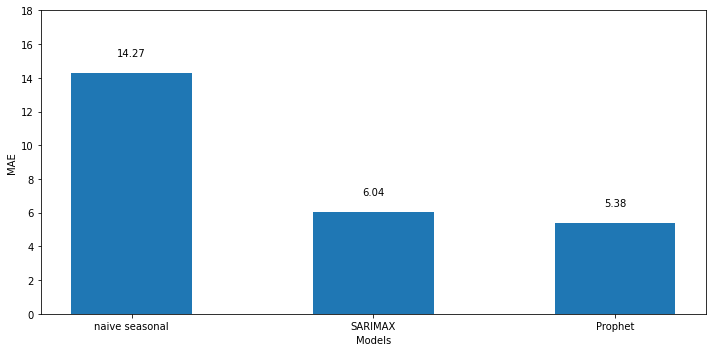

In [41]:
fig, ax = plt.subplots(figsize =(10, 5))

x = ['naive seasonal', 'SARIMAX', 'Prophet']
y = [naive_seasonal_mae, sarimax_mae, prophet_mae]

ax.bar(x, y, width=0.5)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 18)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()


Prophet has the lowest MAE score of 5.38 compared to SARIMAX (6.04) and Naive Seasonal model (14.27). Thus will be using Prophet to predict Dec-20 Sales. 

## 4. Predictions

In [42]:
#obtaing Dec-20 AdvertisingSpend Data for predictions
dec_cols_df = pd.read_csv("data/DecemberCols.csv", names = ['col_name'])
dec_cols = dec_cols_df['col_name'].values.tolist()
dec_ad_df = pd.read_csv("data/DecemberAdData.csv", names = dec_cols)
dec_ad_df['Date'] = dec_ad_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%d/%m/%y'))
dec_ad_df.set_index('Date', drop = False, inplace = True)
dec_ad_df.head()

,Date,AdvertisingSpend,Month,Day
Date,,,,
2020-12-01,2020-12-01,10568.28,December,Tuesday
2020-12-02,2020-12-02,8218.31,December,Wednesday
2020-12-03,2020-12-03,4907.38,December,Thursday
2020-12-04,2020-12-04,8057.25,December,Friday
2020-12-05,2020-12-05,21481.50,December,Saturday


In [43]:
#Using cleaned data for prophet modelling from step 3.1
train = prophet_df.copy()
print(prophet_df.shape)
prophet_df.head()

(1796, 3)


,ds,y,AdvertisingSpend
Date,,,
2016-01-01,2016-01-01,66,4199.86
2016-01-02,2016-01-02,84,14768.20
2016-01-03,2016-01-03,78,11019.79
2016-01-04,2016-01-04,70,3358.30
2016-01-05,2016-01-05,73,5207.19


In [44]:
#training the data 
m = Prophet()
m.add_regressor('AdvertisingSpend')
m.fit(train)

#we want to forecast the next Dec-20 which has 31 days hence period is 31
future = m.make_future_dataframe(periods=31) 


21:01:21 - cmdstanpy - INFO - Chain [1] start processing
21:01:22 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
#Merging full training set with Dec-20 advertising data
full_df = df[['AdvertisingSpend', 'Date']].append(dec_ad_df[['AdvertisingSpend', 'Date']]).sort_index()
full_df.tail(8)

,AdvertisingSpend,Date
Date,,
2020-12-24,16229.29,2020-12-24
2020-12-25,250.69,2020-12-25
2020-12-26,13832.60,2020-12-26
2020-12-27,964.54,2020-12-27
2020-12-28,578.13,2020-12-28
2020-12-29,29203.62,2020-12-29
2020-12-30,12686.89,2020-12-30
2020-12-31,9415.00,2020-12-31


In [46]:
#Appending regressor advertising spend for entire dataset, training and test sets which will be used during predictions
future = future.merge(full_df[['AdvertisingSpend', 'Date']].rename({'Date':'ds'}, axis = 1), on ='ds', how = 'left' )

In [47]:
#predicting Sales with Advertising spend as regressor
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1822,2020-12-27,84.755847,72.188031,96.086060
1823,2020-12-28,80.343218,69.571702,92.092978
1824,2020-12-29,117.909792,106.407980,129.961200
1825,2020-12-30,91.363225,79.772249,103.060949
1826,2020-12-31,83.563642,72.291583,95.787095


In [48]:
#only interested with Dec-20 predicted values
forecast_df = forecast[-31:].set_index('ds', drop = False)
forecast_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,AdvertisingSpend,AdvertisingSpend_lower,AdvertisingSpend_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-12-01,2020-12-01,70.474844,94.956081,118.806817,70.474844,70.474844,3.848323,3.848323,3.848323,36.826154,...,-0.612498,-0.612498,-0.612498,33.590328,33.590328,33.590328,0.0,0.0,0.0,107.300998
2020-12-02,2020-12-02,70.466289,94.255293,116.785047,70.466289,70.466289,0.459041,0.459041,0.459041,34.760326,...,-0.113596,-0.113596,-0.113596,34.414881,34.414881,34.414881,0.0,0.0,0.0,105.226615
2020-12-03,2020-12-03,70.457733,89.448547,112.706507,70.457733,70.457733,-4.316201,-4.316201,-4.316201,31.054561,...,0.053634,0.053634,0.053634,35.317128,35.317128,35.317128,0.0,0.0,0.0,101.512294
2020-12-04,2020-12-04,70.449178,95.630215,118.455411,70.449178,70.449178,0.226750,0.226750,0.226750,36.487219,...,-0.019846,-0.019846,-0.019846,36.280315,36.280315,36.280315,0.0,0.0,0.0,106.936397
2020-12-05,2020-12-05,70.440622,115.329310,138.783264,70.440622,70.440622,19.588089,19.588089,19.588089,56.889472,...,0.016774,0.016774,0.016774,37.284609,37.284609,37.284609,0.0,0.0,0.0,127.330094


In [49]:
#Appending predicted data with Dec-20 data provided by the marketing team
Dec20_predicted_values = forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-31:]
Dec20_predicted_values['AdvertisingSpend']   = dec_ad_df['AdvertisingSpend']

In [50]:
#Dec-20 predictions
Dec20_predicted_values

,ds,yhat,yhat_lower,yhat_upper,AdvertisingSpend
ds,,,,,
2020-12-01,2020-12-01,107.300998,94.956081,118.806817,10568.28
2020-12-02,2020-12-02,105.226615,94.255293,116.785047,8218.31
2020-12-03,2020-12-03,101.512294,89.448547,112.706507,4907.38
2020-12-04,2020-12-04,106.936397,95.630215,118.455411,8057.25
2020-12-05,2020-12-05,127.330094,115.329310,138.783264,21481.50
2020-12-06,2020-12-06,98.776039,87.340203,110.119485,484.17
2020-12-07,2020-12-07,115.852333,104.505944,127.409688,12172.13
2020-12-08,2020-12-08,111.684334,99.920198,122.995713,8991.64
2020-12-09,2020-12-09,123.420700,111.448474,135.197786,16149.41


In [51]:
#Total predicted sales for Dec-2020
print("Total Dec_20 prediction:", round(Dec20_predicted_values.yhat.sum(), 0))
print("Dec_20 upper bound prediction:", round(Dec20_predicted_values.yhat_upper.sum(), 0))
print("Dec_20 lower bound prediction:", round(Dec20_predicted_values.yhat_lower.sum(), 0))

Total Dec_20 prediction: 3362.0
Dec_20 upper bound prediction: 3720.0
Dec_20 lower bound prediction: 2999.0


## 5. Summary

Below figure is the plots the predictions using Prophet. 
The black dots represent the training data, while the solid continuous line represents the model’s predictions. 
The shaded band surrounding the line represents an 80% confidence interval.

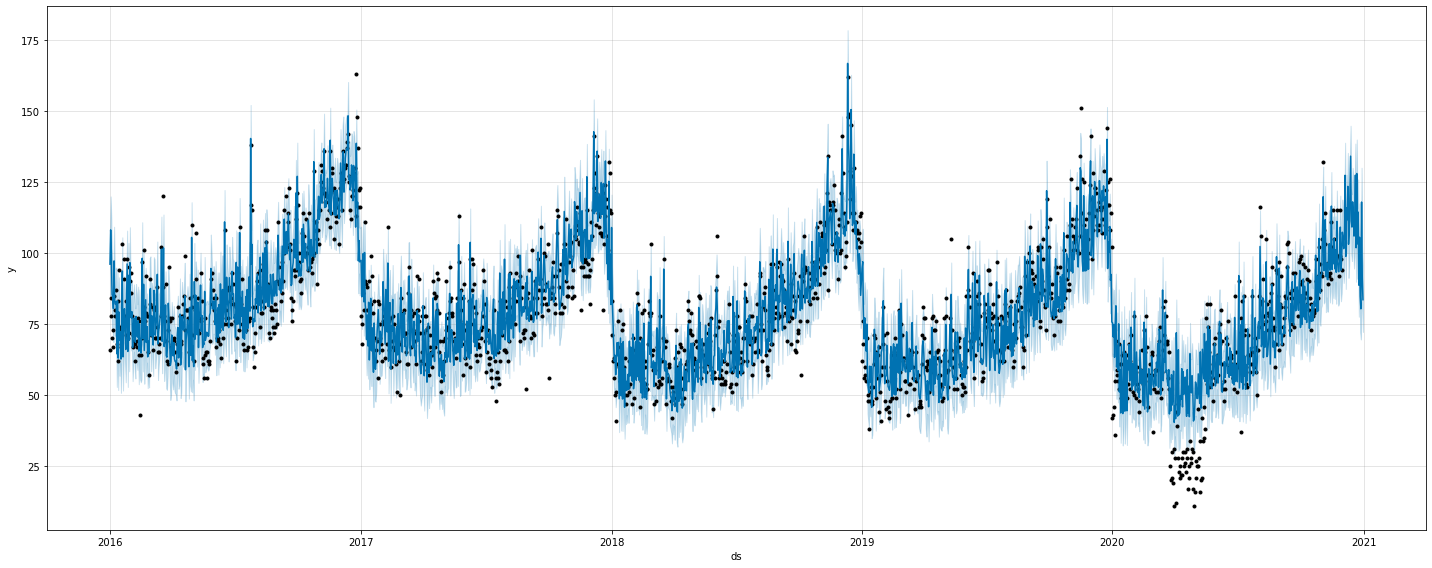

In [52]:
#Plotting the prediction
fig1 = m.plot(forecast, figsize =(20, 8))

Vac-Attack aims to sell 3,900 units in December 2020. Based on the predictions using Prophet we estimate that the total Dec-20 sales is between 3002 and 3,723 (with 80% confidence). This is lower than what Vac-attack has aimed which may mean that the marketing team might need to look at their current marketing strategy to increased sales or are they being ambitious with their goal.  It is evident with the plot above tha the model did not perform well with predicting sales during COVID lockdown which is expected as it is an unforeseen event.  Hopefully, the marketing team have contingencies in place for unforeseen events such as COVID lockdown.

Prophet was the suitable model for the predicting Vac-Attack sales due to multiple periodic effects where we see increased on sales during weekends and end of the year sales which it was able to capture. There is an advance option to tune the parameters in Prophet, i.e., changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, and seasonality_mode. However, comparing Prophet alread performed well even without tuning the hyper parameters. The main advantage of Prophet library is that it allows us to quicly experiment and genrate predictions. A limitation with prophet is that it works well only where there is strong seasonality in the data.

Meanwhile, SARIMAX required several checks before we can perform any modelling with SARIMAX which was a tedious process. I have that found optimising SARIMAX parameter with this current data computationally exhaustive. 

There are other models that might be appropriate for such a complex data such as lightGBM or using deep learning models such as LSTM or CNN that can be explored in the future.


## 6. References

1. Peixeiro, M. (2022). "Time Series Forecasting in Python". Shelter Island, New York: Manning Publications.

2. Hyndman, R. J. & Athanasopoulos, G (2021)."Forecasting: Principles and Practice" (https://otexts.com/fpp3/)

3. https://towardsdatascience.com/multi-step-time-series-forecasting-with-arima-lightgbm-and-prophet-cc9e3f95dfb0

4. https://medium.com/geekculture/how-to-forecast-sales-with-advertising-spend-in-r-36e6fc99760a

5. https://towardsdatascience.com/forecast-model-tuning-with-additional-regressors-in-prophet-ffcbf1777dda

6. https://www.statsmodels.org/v0.13.0/examples/notebooks/generated/statespace_sarimax_stata.html

7. https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b